In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

### Борьба с дисбалансом классов

Будем решать задачу распознавания спама  
[Ссылка для ознакомления с данными](https://archive.ics.uci.edu/dataset/94/spambase)

In [2]:
res = []
with open('spambase.names', 'r') as f:
    res = f.readlines()
    
f_names = [f.split(':')[0] for f in res[33:]]

In [3]:
df = pd.read_csv('spambase.data', header=None)
df.columns = f_names + ['target']
df.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,target
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


Посмотрим распределение по классам

In [4]:
df['target'].value_counts()

target
0    2788
1    1813
Name: count, dtype: int64

Подготовим выборку к обучению 

In [5]:
features = df.drop(['target'], axis=1)
target = df['target']
features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=34, test_size=0.3)

In [6]:
target_train.value_counts()

target
0    1969
1    1251
Name: count, dtype: int64

In [7]:
target_test.value_counts()

target
0    819
1    562
Name: count, dtype: int64

Обучим логистическую регрессию и оценим качество

In [8]:
model = LogisticRegression(random_state=1, solver='liblinear')
model.fit(features_train, target_train)
predict_test = model.predict(features_test)
print('Значение F1-метрики:', f1_score(predict_test, target_test))

Значение F1-метрики: 0.918531781557744


In [9]:
pd.Series(predict_test).value_counts()

0    826
1    555
Name: count, dtype: int64

Укажем алгоритму, что в лоссе необходимо учитывать более редкий класс с большим весом 

In [10]:
model = LogisticRegression(random_state=1, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predict_test = model.predict(features_test)
print('Значение F1-метрики:', f1_score(predict_test, target_test))

Значение F1-метрики: 0.9226713532513181


Увеличим количество объектов более редкого класса в обучающей выборке. Для этого реализуем фукнцию, которая будет принимать на вход фичи и значения целевого признака для объектов из обучающей выборке, а возвращать новые фичи и значения целевого класса, где для объектов более редкого класса будет по несколько задублированных записей

In [11]:
def upsample(features, target, repeat=10):
    # разделяем объекты разных классов и информацию о них по разным переменным
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    # дублируем записи объектов более редкого класса
    if len(target_ones) > len(target_zeros):
        repeat = round(len(target_ones) / len(target_zeros))
        features_upsampled = pd.concat([features_ones] + [features_zeros] * repeat)
        target_upsampled = pd.concat([target_ones] + [target_zeros] * repeat)
    else:
        repeat = round(len(target_zeros) / len(target_ones))
        features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
        target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    # перемешиваем объекты
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=23)
    
    return features_upsampled, target_upsampled

In [12]:
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train)

In [13]:
target_train_upsampled.value_counts()

target
1    2502
0    1969
Name: count, dtype: int64

In [14]:
model = LogisticRegression(random_state=1, solver='liblinear')
model.fit(features_train_upsampled, target_train_upsampled)
predict_test = model.predict(features_test)
print('Значение F1-метрики:', f1_score(predict_test, target_test))

Значение F1-метрики: 0.9197584124245038


Попробуем подобрать такой порог классификации, чтобы повысить качество на валидационной выборке

In [15]:
model = LogisticRegression(random_state=1, solver='liblinear')
model.fit(features_train, target_train)
predict_proba_test = model.predict_proba(features_test)

In [16]:
res = []
for cutoff_ in range(0, 100, 5):
    cutoff = cutoff_ / 100
    pred_cutoff_test = (1 * (pd.Series(predict_proba_test[:, 1]) >= cutoff))
    res.append([cutoff, f1_score(pred_cutoff_test, target_test)])

<Axes: xlabel='cutoff'>

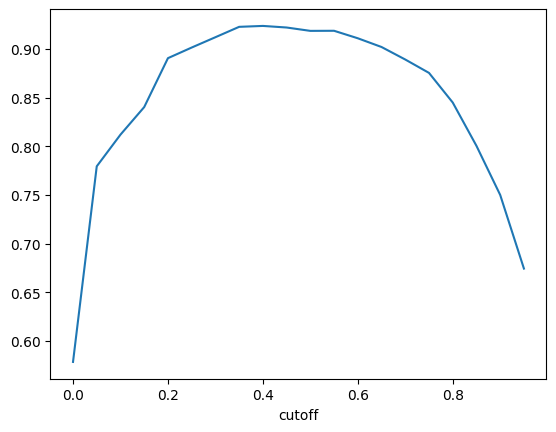

In [17]:
res_pd = pd.DataFrame(res, columns = ['cutoff', 'f1_score'])
res_pd.set_index('cutoff')['f1_score'].plot()

In [18]:
res_pd[res_pd['f1_score'] == res_pd['f1_score'].max()]

,cutoff,f1_score
8,0.4,0.923617


### Метрики качества

Изобразим на графике, как выглядят значения метрик precision и recall при изменении порога.

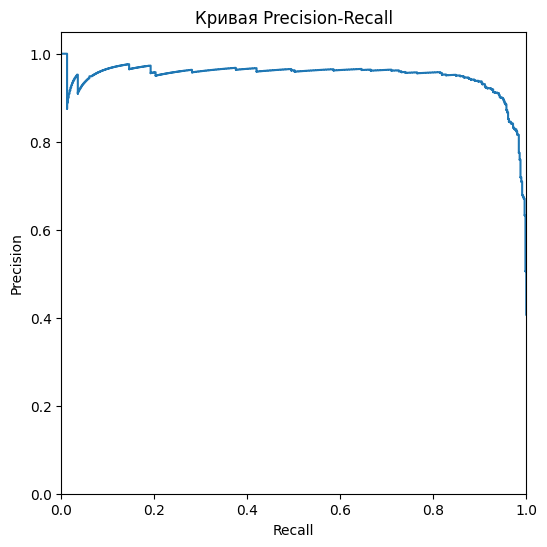

In [19]:
precision, recall, thresholds = precision_recall_curve(target_test, pd.Series(predict_proba_test[:, 1]))

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show() 

Построим ROC-кривую

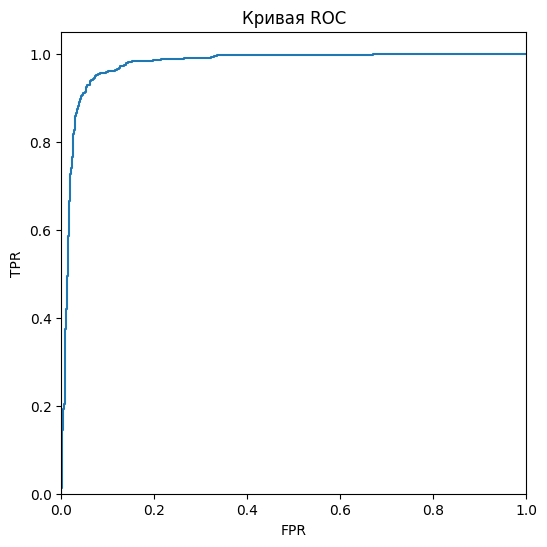

In [20]:
fpr, tpr, thresholds = roc_curve(target_test, predict_proba_test[:, 1])

plt.figure(figsize=(6, 6))
plt.step(fpr, tpr, where='post')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая ROC')
plt.show() 

Посчитаем значение метрики ROC-AUC

In [21]:
print(f'ROC-AUC = {roc_auc_score(target_test, predict_proba_test[:, 1])}')

ROC-AUC = 0.9759080381856183


### Работа с пропусками

Изучим данные о пассажирах титаника ([ссылка](https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/problem12.html)).

In [22]:
titanic_data = pd.read_csv('titanic_mv.csv')
titanic_data.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,NaN


In [23]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Survived                 887 non-null    int64  
 1   Pclass                   887 non-null    int64  
 2   Name                     887 non-null    object 
 3   Sex                      811 non-null    object 
 4   Age                      887 non-null    float64
 5   Siblings/Spouses Aboard  887 non-null    int64  
 6   Parents/Children Aboard  887 non-null    int64  
 7   Fare                     757 non-null    float64
dtypes: float64(2), int64(4), object(2)
memory usage: 55.6+ KB


Посмотрим, можем ли мы заполнить информацию о поле на основании имени пассажира.

In [24]:
perf_sex_mapping = set(titanic_data.dropna(subset='Sex').apply(lambda f: (f['Name'].split()[0], f['Sex']), axis=1))
perf_sex_mapping

{('Capt.', 'male'),
 ('Col.', 'male'),
 ('Don.', 'male'),
 ('Dr.', 'female'),
 ('Dr.', 'male'),
 ('Jonkheer.', 'male'),
 ('Lady.', 'female'),
 ('Major.', 'male'),
 ('Master.', 'male'),
 ('Miss.', 'female'),
 ('Mlle.', 'female'),
 ('Mme.', 'female'),
 ('Mr.', 'male'),
 ('Mrs.', 'female'),
 ('Ms.', 'female'),
 ('Rev.', 'male'),
 ('Sir.', 'male'),
 ('the', 'female')}

In [25]:
titanic_data['Sex'] = (
    titanic_data
    .apply(
        lambda f: dict(perf_sex_mapping)[f['Name'].split()[0]], axis=1
    )
)

Посмотрим, можем ли мы заполнить информацию о стоимости билета на основании класса

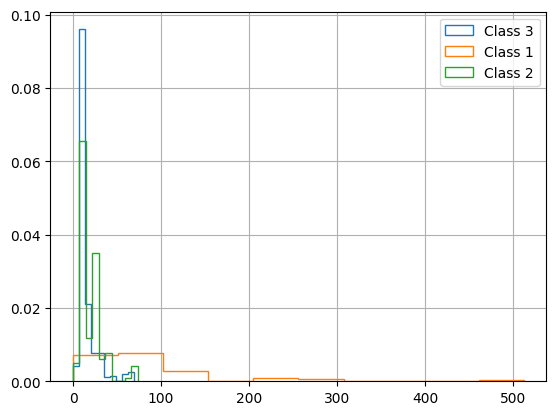

In [26]:
for Pclass in titanic_data['Pclass'].unique():
    (
        titanic_data
        .dropna(subset=['Fare'])
        .query('Pclass == @Pclass')['Fare']
        .hist(
            histtype='step', 
            label=f'Class {Pclass}',
            density=True
        )
    )
plt.legend();

In [27]:
class_to_fare_mapping = dict(
    titanic_data
    .dropna(subset=['Fare'])
    .groupby('Pclass')['Fare']
    .median()
)
class_to_fare_mapping

{1: np.float64(67.94999999999999),
 2: np.float64(13.93125),
 3: np.float64(8.05)}

In [28]:
titanic_data['Fare'] = titanic_data.apply(lambda f: f['Fare'] if pd.notna(f['Fare']) else class_to_fare_mapping[f['Pclass']], axis=1)

In [29]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Survived                 887 non-null    int64  
 1   Pclass                   887 non-null    int64  
 2   Name                     887 non-null    object 
 3   Sex                      887 non-null    object 
 4   Age                      887 non-null    float64
 5   Siblings/Spouses Aboard  887 non-null    int64  
 6   Parents/Children Aboard  887 non-null    int64  
 7   Fare                     887 non-null    float64
dtypes: float64(2), int64(4), object(2)
memory usage: 55.6+ KB


### Прямое кодирование

In [30]:
features = titanic_data.drop(['Survived', 'Name'], axis=1)
target = titanic_data['Survived']

Обработаем поле "Пол"

In [31]:
features_ohe = pd.get_dummies(features)
features_ohe.head()

,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Sex_female,Sex_male
0,3,22.0,1,0,7.2500,False,True
1,1,38.0,1,0,71.2833,True,False
2,3,26.0,0,0,7.9250,True,False
3,1,35.0,1,0,53.1000,True,False
4,3,35.0,0,0,8.0500,False,True


In [32]:
features_ohe_2 = pd.get_dummies(features, drop_first=True)
features_ohe_2.head()

,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Sex_male
0,3,22.0,1,0,7.2500,True
1,1,38.0,1,0,71.2833,False
2,3,26.0,0,0,7.9250,False
3,1,35.0,1,0,53.1000,False
4,3,35.0,0,0,8.0500,True


In [33]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_ohe_2, target, test_size=0.25, random_state=23
)
model = LogisticRegression(solver='liblinear', random_state=12, class_weight='balanced')
model.fit(features_train, target_train)
roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])

np.float64(0.8222242512783052)

In [34]:
pd.DataFrame(
    zip(list(features_ohe_2.columns), list(abs(model.coef_[0]))), 
    columns=['feature', 'importance']
).sort_values(by=['importance'], ascending=False)

,feature,importance
5,Sex_male,2.297604
0,Pclass,0.658748
2,Siblings/Spouses Aboard,0.329690
3,Parents/Children Aboard,0.077757
1,Age,0.031958
4,Fare,0.013717


### Масштабирование признаков

In [35]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train_sc = scaler.transform(features_train)
features_valid_sc = scaler.transform(features_valid)

In [36]:
pd.DataFrame(features_train_sc, columns=features_train.columns).head()

,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Sex_male
0,0.853538,-0.735564,-0.477746,-0.470131,-0.499798,0.758834
1,-1.536369,-0.158232,0.435188,-0.470131,0.426797,0.758834
2,0.853538,-0.807731,0.435188,0.871659,-0.247330,0.758834
3,0.853538,-0.302565,0.435188,-0.470131,-0.499199,-1.317811
4,0.853538,0.274767,-0.477746,-0.470131,-0.499798,0.758834


In [37]:
model = LogisticRegression(solver='liblinear', random_state=12, class_weight='balanced')
model.fit(features_train_sc, target_train)
roc_auc_score(target_valid, model.predict_proba(features_valid_sc)[:, 1])

np.float64(0.8320854638422206)

In [38]:
pd.DataFrame(
    zip(list(features_ohe_2.columns), list(abs(model.coef_[0]))), 
    columns=['feature', 'importance']
).sort_values(by=['importance'], ascending=False)

,feature,importance
5,Sex_male,1.236697
0,Pclass,0.869814
1,Age,0.625018
2,Siblings/Spouses Aboard,0.385588
4,Fare,0.362680
3,Parents/Children Aboard,0.085698


### Кросс-валидация

In [39]:
model = LogisticRegressionCV(solver='liblinear', random_state=12, class_weight='balanced', cv=10)
model.fit(features_train_sc, target_train)
roc_auc_score(target_valid, model.predict_proba(features_valid_sc)[:, 1])

np.float64(0.8319941563184806)

In [40]:
pd.DataFrame(
    zip(list(features_ohe_2.columns), list(abs(model.coef_[0]))), 
    columns=['feature', 'importance']
).sort_values(by=['importance'], ascending=False)

,feature,importance
5,Sex_male,1.248754
0,Pclass,0.883198
1,Age,0.638083
2,Siblings/Spouses Aboard,0.392947
4,Fare,0.363823
3,Parents/Children Aboard,0.088885
